今回利用するコンペのデータはこちらです。

ECサイト（オンラインストア）の購買データ

https://www.kaggle.com/datasets/ulrikthygepedersen/online-retail-dataset

# データダウンロード

・データは、Kaggleの過去のコンペティションで使われたデータを利用します<br>
　そのため、必ずKaggleのアカウント作成をお願いします

・データ取得は、Kaggle APIを利用します。KaggleのAPIの使い方は下記を参照してください<br>
　https://take-tech-engineer.com/kaggle-colab-api/

In [175]:
# KaggleのAPIを利用ためのインストール
!pip install kaggle

In [176]:
# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
# KaggleのAPIを利用するための設定
# 初回のみJSONファイルをダウンロードして、Google Driveに保存する必要がある

import os
import json
f = open("/content/drive/MyDrive/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

# データ準備

In [178]:
from PIL import Image

In [179]:
# 標準ライブラリ
import pandas as pd
import numpy as np

In [180]:
# Kaggleの各コンペページから、APIコマンドを取得し実施
# 今回は「Doenload(8MB)」の横にある縦3点リーダの中にある「Copy API command」をクリックした取得した
!kaggle datasets download -d ulrikthygepedersen/online-retail-dataset

online-retail-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [181]:
# !unzip <ダウンロードしたZIPファイル>
#!unzip '/content/online-retail-dataset.zip'

Archive:  /content/online-retail-dataset.zip
replace online_retail.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [182]:
# 解凍したZIPには、CSVファイルが含まれている。CSVファイルを読み込んで、Pandasデータフレーム化する
df = pd.read_csv('/content/online_retail.csv')   # ディレクトリに注意

# 確認用に出力
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [183]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

InvoiceNo = 請求書番号

StockCode = 証券コード(おそらく商品番号)

Description = 説明(購入品)

Quantity = 量(数量)

InvoiceDate = 請求日付

UnitPrice = 単価

CustomerID = 顧客番号

Country = 国



---



In [184]:
# カラムごとの基準統計量
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


標準偏差が大きいため外れ値の影響を受けている可能性あり。

In [185]:
# カラム事の欠損値数
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Description(購入品目)とCustomerID(顧客番号)に欠損値がある。

CustomerIDの欠損値多い。



---



In [186]:
# 購買データ用処理
## マイナス値は返品等のため、除外してください

マイナス値になりうるのはQuantityとUnitPriceか。

<Axes: xlabel='Quantity'>

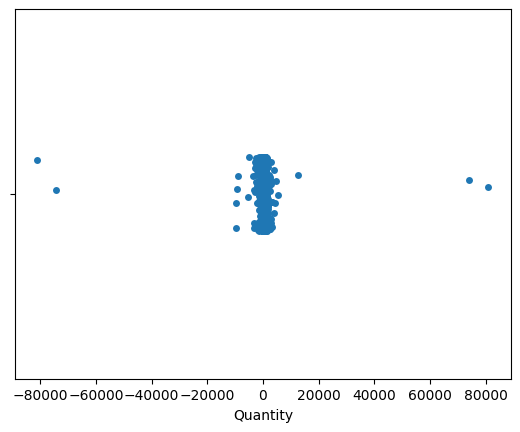

In [187]:
#Quantityをプロットグラフで可視化
import seaborn as sns
sns.stripplot(x='Quantity', data=df)

0から対称になっている？

<Axes: xlabel='UnitPrice'>

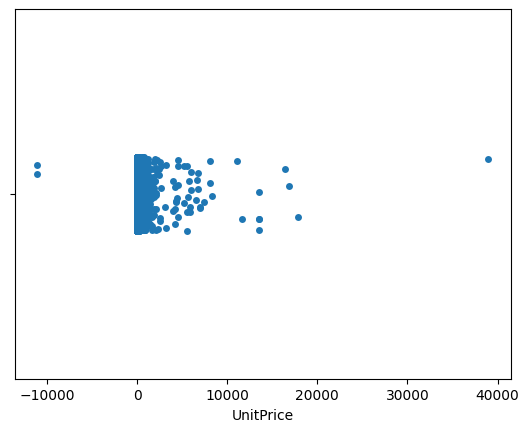

In [188]:
#UnitPriceをプロットグラフで可視化
import seaborn as sns
sns.stripplot(x='UnitPrice', data=df)

0未満（以下？)、30000以上に外れ値らしきものがある。

量と単価の０に意味はないと思われるので０を含んで除外する。

In [189]:
quantity_minus = df.query('Quantity <= 0')
quantity_minus.shape

(10624, 8)

In [190]:
quantity_minus = df.query('UnitPrice <= 0')
quantity_minus.shape

(2517, 8)

In [191]:
#マイナス値のあるQuantityカラムまたはUnitPriceカラム
df_minus = df.query('Quantity <= 0 or UnitPrice <= 0')
df_minus.shape

(11805, 8)

In [192]:
#マイナス値を除外した総行数の確認
exclude_minus = (df.shape[0]) - (df_minus.shape[0])
exclude_minus

530104

In [193]:
#マイナス値を除外したデータ
df = df.drop(df_minus.index, axis=0)
df.shape

(530104, 8)

☎

マイナス値を除去すれば返品の値は除去されるが、購買数はそのままである。

今マイナス値は除去された状況だが、本来買う予定ではなかったものも総計としてでてしまうのではないか。

返品された商品ごとにマイナス値を除去するべきなのかどうか確認する。

**A**

今回は商品ごとにマイナス値を除去しないで実施していく。

<Axes: xlabel='Quantity'>

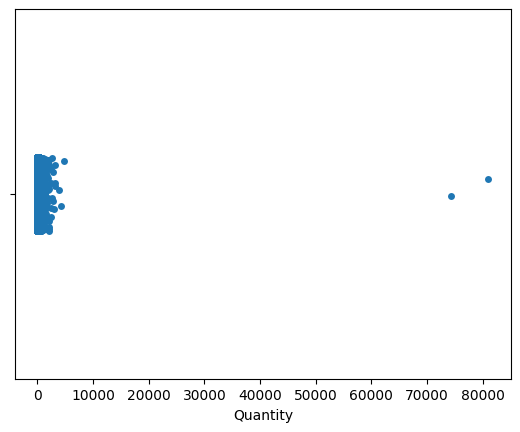

In [194]:
sns.stripplot(x='Quantity', data=df)

Quantityにボリュームゾーンから離れた値がある。

In [195]:
df.query('Quantity > 10000').shape

(2, 8)

In [196]:
df.query('Quantity > 10000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


☎

InvoiceNo.541431は小さい保存瓶だが7万も買うだろうか？

InvoiceNo.581483はPAPERCRAFTなのでありえなくもないのか。

それぞれ一回の買い物で購入するには量がおかしく、50万件以上中3件のデータである。

平均値からの距離も遠い。

発注ミス、システム上のミスと見なし除外してもよいか確認する。

**A**

可視化して外れ値と思われるものは除外していく。



In [197]:
df = df.drop(df.query('Quantity > 10000').index)

<Axes: xlabel='Quantity'>

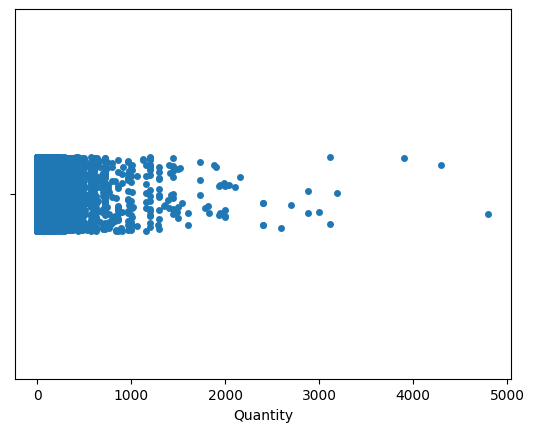

In [198]:
sns.stripplot(x='Quantity', data=df)

In [199]:
df.query('Quantity > 3500')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom


In [200]:
df = df.drop(df.query('Quantity > 3500').index)

<Axes: xlabel='Quantity'>

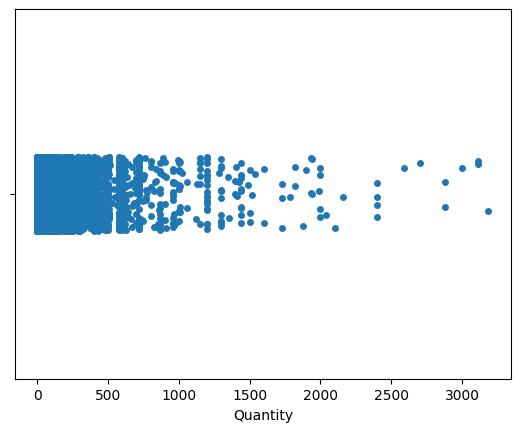

In [201]:
sns.stripplot(x='Quantity', data=df)

きりがないので「第3四分位数＋1.5×四分位範囲」以上を外れ値とする。

In [202]:
#Quantityの四分位範囲から外れ値を除去する。
10 + 1.5 * 10

25.0

In [203]:
df = df.drop(df.query('Quantity > 25').index)

<Axes: xlabel='Quantity'>

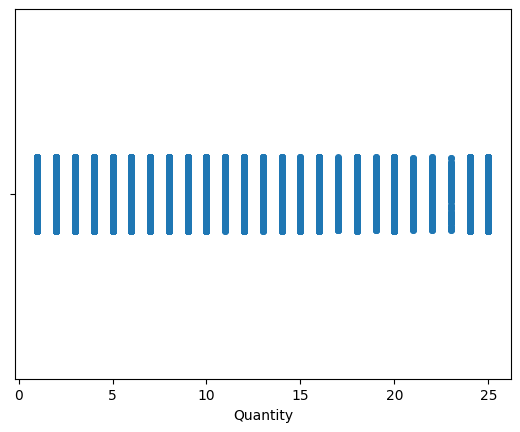

In [204]:
sns.stripplot(x='Quantity', data=df)

In [205]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,502865.000000,502865.000000,372154.000000
mean,5.843634,4.033230,15309.527951
std,6.264973,36.858116,1711.576035
min,1.000000,0.001000,12347.000000
25%,1.000000,1.250000,13985.000000
50%,3.000000,2.100000,15194.000000
75%,10.000000,4.130000,16813.000000
max,25.000000,13541.330000,18287.000000


☎

UnitPriceも平均値と標準偏差の差が大きいが除外するべきか？

**A**

UnitPriceは商品単価であるため、あまり除かない方がいい。

☎

商品単価が＄13541＝140万円？であることもある。

固定されたあらかじめ決められた値であるため除かない方が良いということか。

In [206]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom




---



# データ可視化

Matplotlibだけでも構いませんが、Seabornというライブラリを使うとより見やすいグラフが作成できるので、下記を参照してください。

https://udemy.benesse.co.jp/development/python-work/seaborn-python.html

下記データ可視化の処理が短時間で完了しない場合、最初の10000件のサンプルファイルで実施してください
```
df_sample = df.head(10000)
```

In [207]:
# データ見える化ライブラリ
import seaborn as sns
import matplotlib.pyplot as plt



---



In [208]:
# ヒストグラム
# レコードごとの購入金額（UnitPrice * Quantity)をX軸に描写

In [209]:
#行ごとに購入金額（UnitPrice * Quantity)を計算しTotalValue列に入れる。
df['TotalValue'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


TotalValue = 購入金額（UnitPrice * Quantity)


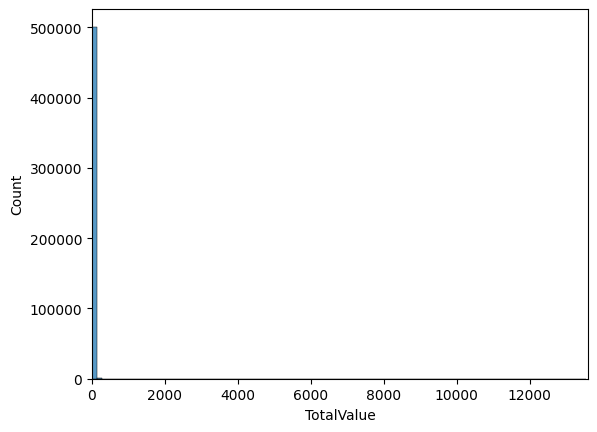

In [210]:
print('TotalValue = 購入金額（UnitPrice * Quantity)')
sns.histplot(data=df, x='TotalValue', bins=100)
plt.xlim(0, 13600)
plt.show()

<Axes: xlabel='TotalValue'>

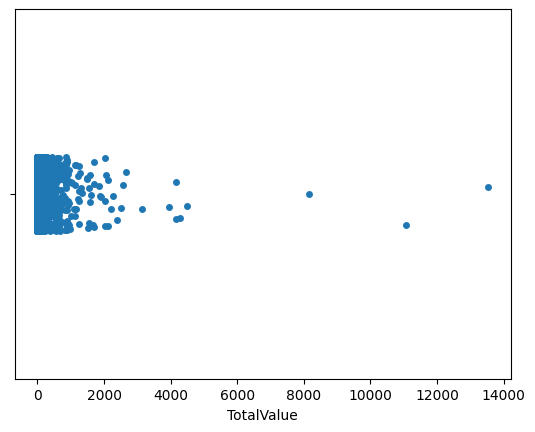

In [211]:
sns.stripplot(x='TotalValue', data=df)

In [212]:
df.query('TotalValue > 8000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom,13541.33
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,8142.75
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,11062.06


☎

この外れ値は除外していいものなのか。

**A**

件数しかないのであれば、除いてしまっても問題ないかもしれない。

50万件のうちの数件であり、内容も分析にとってあまり重要ではないように思えるため除外する。

In [213]:
df['TotalValue'].describe()

count    502865.000000
mean         13.489834
std          40.009229
min           0.001000
25%           3.750000
50%           8.500000
75%          16.600000
max       13541.330000
Name: TotalValue, dtype: float64

In [214]:
df = df.drop(df.query('TotalValue > 6000').index)

<Axes: xlabel='TotalValue'>

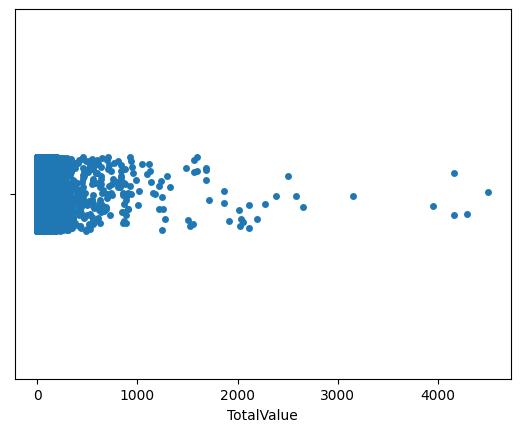

In [215]:
sns.stripplot(x='TotalValue', data=df)

In [216]:
df['TotalValue'].describe()

count    502862.000000
mean         13.424795
std          29.370915
min           0.001000
25%           3.750000
50%           8.500000
75%          16.600000
max        4505.170000
Name: TotalValue, dtype: float64

TotalValue = 購入金額（UnitPrice * Quantity)


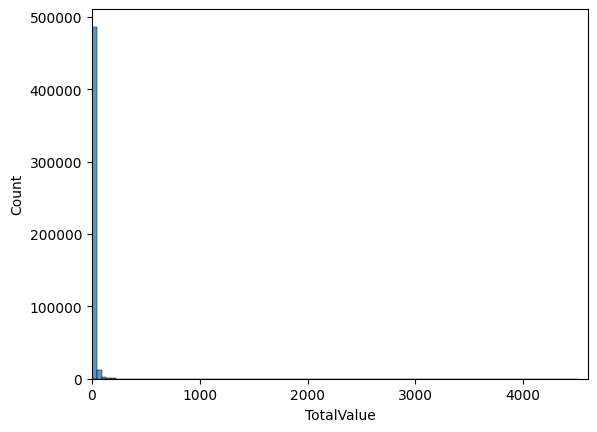

In [217]:
print('TotalValue = 購入金額（UnitPrice * Quantity)')
sns.histplot(data=df, x='TotalValue', bins=100)
plt.xlim(0, 4600)
plt.show()

☎

データが偏っており読み取りづらいのはどう解消すればよいか。

**A**

TotalValueの値が0~2000に絞ってだす

df["TotalValue"].clip(0, 2000)

というのも並行して実施してみる。

In [218]:
df['TotalValue'].mode()

0    15.0
Name: TotalValue, dtype: float64

TotalValue = 購入金額（UnitPrice * Quantity)


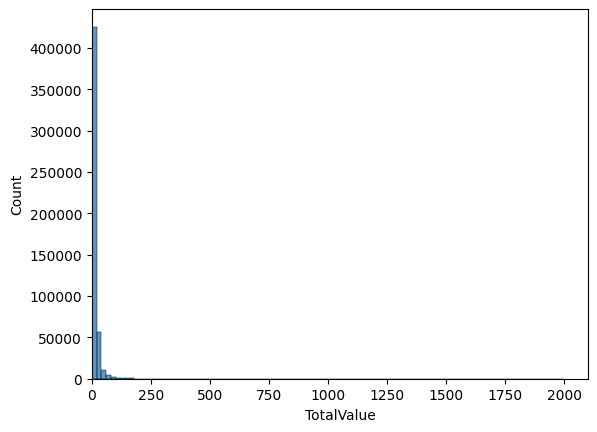

In [219]:
# TotalValueの値が0~2000に絞ってだす
print('TotalValue = 購入金額（UnitPrice * Quantity)')
sns.histplot(data=df, x=df["TotalValue"].clip(0, 2000), bins=100)
plt.xlim(0, )
plt.show()

TotalValue = 購入金額（UnitPrice * Quantity)


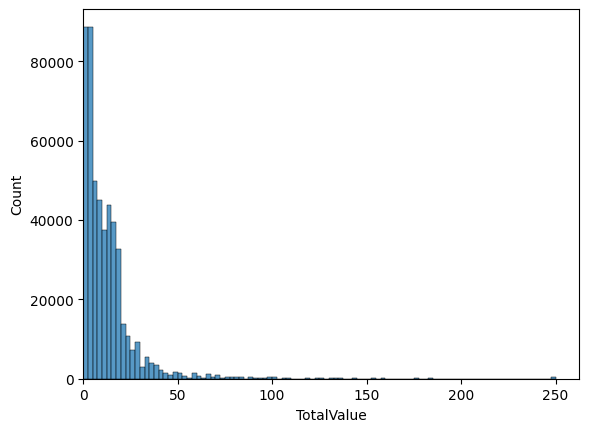

In [220]:
# まだ見にくいのでTotalValueの値が0~250に絞ってだす
print('TotalValue = 購入金額（UnitPrice * Quantity)')
sns.histplot(data=df, x=df["TotalValue"].clip(0, 250), bins=100)
plt.xlim(0, )
plt.show()

右に裾の長いヒストグラム



---



In [221]:
# 棒グラフ
# 国ごとをX軸、総購入金額をY軸に描写

In [222]:
def pickup_country_names(df):
    country_names = {}
    for country_name in df['Country']:
        if country_name in country_names:
            country_names[country_name] += 1
        else:
            country_names[country_name] = 1
    return country_names

country_counts = pickup_country_names(df)

for country, count in country_counts.items():
    print(country, count)


United Kingdom 463369
France 7903
Australia 578
Netherlands 787
Germany 8517
Norway 913
EIRE 7029
Switzerland 1771
Poland 314
Portugal 1419
Italy 736
Belgium 1954
Lithuania 29
Japan 115
Iceland 173
Channel Islands 717
Denmark 325
Spain 2378
Cyprus 581
Finland 621
Austria 387
Sweden 281
Israel 263
Greece 142
Hong Kong 234
Singapore 171
Lebanon 45
United Arab Emirates 64
Saudi Arabia 9
Czech Republic 19
Canada 138
Unspecified 439
Brazil 32
USA 167
European Community 60
Bahrain 15
Malta 110
RSA 57


グループ化すればいいのか。

In [223]:
#reset_index()でインデックスをリセットして取得しておく。（しておかないとCountry列がインデックス列になってしまう）
df_country_totalvalue = df.groupby('Country')['TotalValue'].sum().reset_index()
df_country_totalvalue

,Country,TotalValue
0,Australia,18288.590
1,Austria,9221.940
2,Bahrain,353.400
3,Belgium,37682.200
4,Brazil,1143.600
5,Canada,2748.680
6,Channel Islands,16386.730
7,Cyprus,11465.580
8,Czech Republic,634.540
9,Denmark,10319.330


In [224]:
df_country_totalvalue.sum()

Country       AustraliaAustriaBahrainBelgiumBrazilCanadaChan...
TotalValue                                          6750819.064
dtype: object

In [225]:
df['TotalValue'].sum()

6750819.064

In [226]:
df_country_totalvalue.columns

Index(['Country', 'TotalValue'], dtype='object')

シリーズとデータフレームの違い

In [227]:
df_country_totalvalue.describe()

,TotalValue
count,3.800000e+01
mean,1.776531e+05
std,9.446932e+05
min,1.459200e+02
25%,2.668385e+03
50%,8.307215e+03
75%,2.470369e+04
max,5.841299e+06


In [228]:
df_country_totalvalue.columns

Index(['Country', 'TotalValue'], dtype='object')

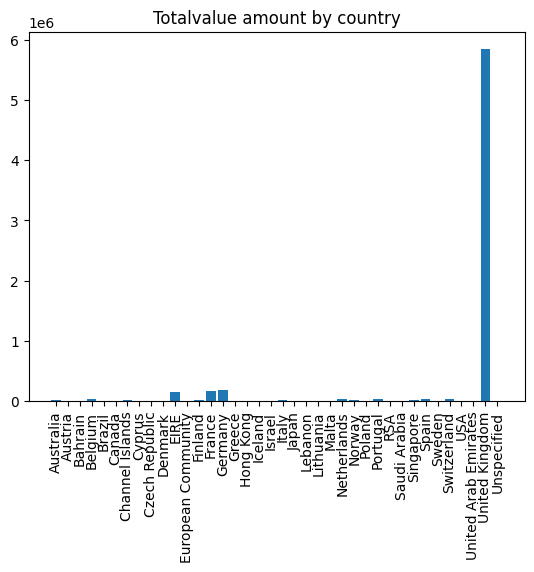

In [229]:
x = df_country_totalvalue['Country']
y = df_country_totalvalue['TotalValue']
plt.title('Totalvalue amount by country')
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()


UnitedKingdomが大きすぎて他が見にくい。

中間範囲を端折る方法はないだろうか。

とりあえずイギリスだけ抜いてみる。

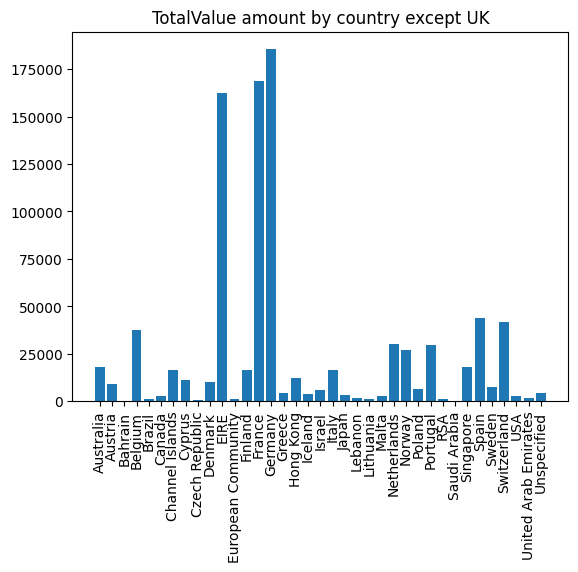

In [230]:
df_except_uk = df_country_totalvalue[df_country_totalvalue['Country'] != 'United Kingdom']

x_except_uk = df_except_uk['Country']
y_except_uk = df_except_uk['TotalValue']
plt.title('TotalValue amount by country except UK')
plt.bar(x_except_uk, y_except_uk)
plt.xticks(rotation=90)
plt.show()

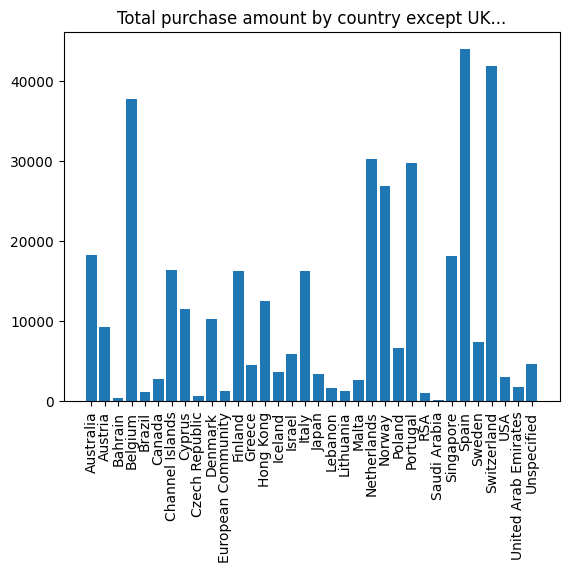

In [231]:
df_except_uk_eire_france_Germany = df_country_totalvalue[
    (df_country_totalvalue['Country'] != 'United Kingdom') &
    (df_country_totalvalue['Country'] != 'EIRE') &
    (df_country_totalvalue['Country'] != 'France') &
    (df_country_totalvalue['Country'] != 'Germany')]

x_except_uk_eire_france_Germany = df_except_uk_eire_france_Germany['Country']
y_except_uk_eire_france_Germany = df_except_uk_eire_france_Germany['TotalValue']
plt.title('Total purchase amount by country except UK...')
plt.bar(x_except_uk_eire_france_Germany, y_except_uk_eire_france_Germany)
plt.xticks(rotation=90)
plt.show()

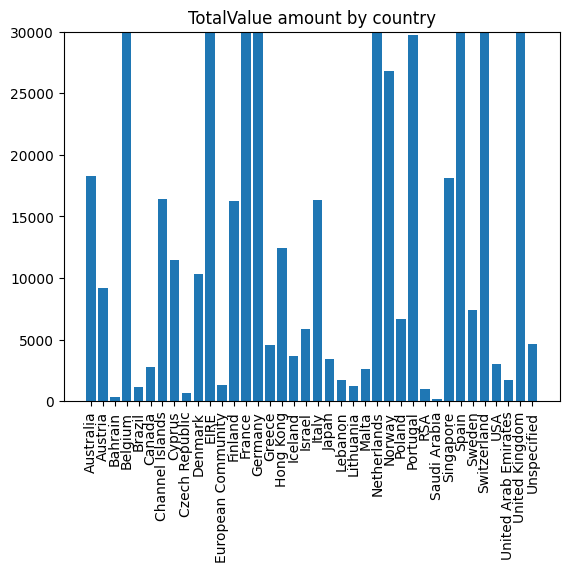

In [232]:
#yの範囲を0～30000してみる。
x = df_country_totalvalue['Country']
y = df_country_totalvalue['TotalValue']
plt.title('TotalValue amount by country')
plt.bar(x, y)
plt.ylim(0, 30000)
plt.xticks(rotation=90)
plt.show()




---



In [233]:
# 散布図
# 個数をX軸、単価をY軸に設定、ポイントの色を国で分けて描写]

In [234]:
df.shape

(502862, 9)

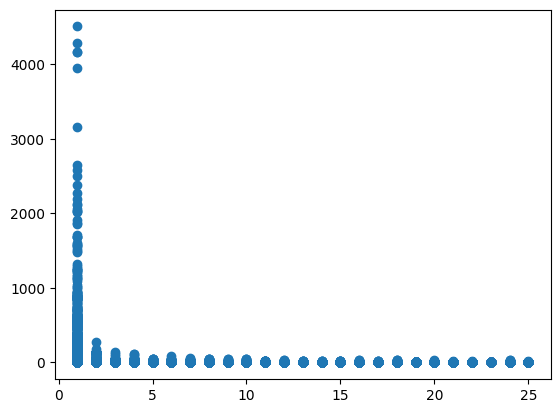

In [235]:
x_scatter = df['Quantity']
y_scatter = df['UnitPrice']

plt.scatter(x_scatter, y_scatter)
plt.show()

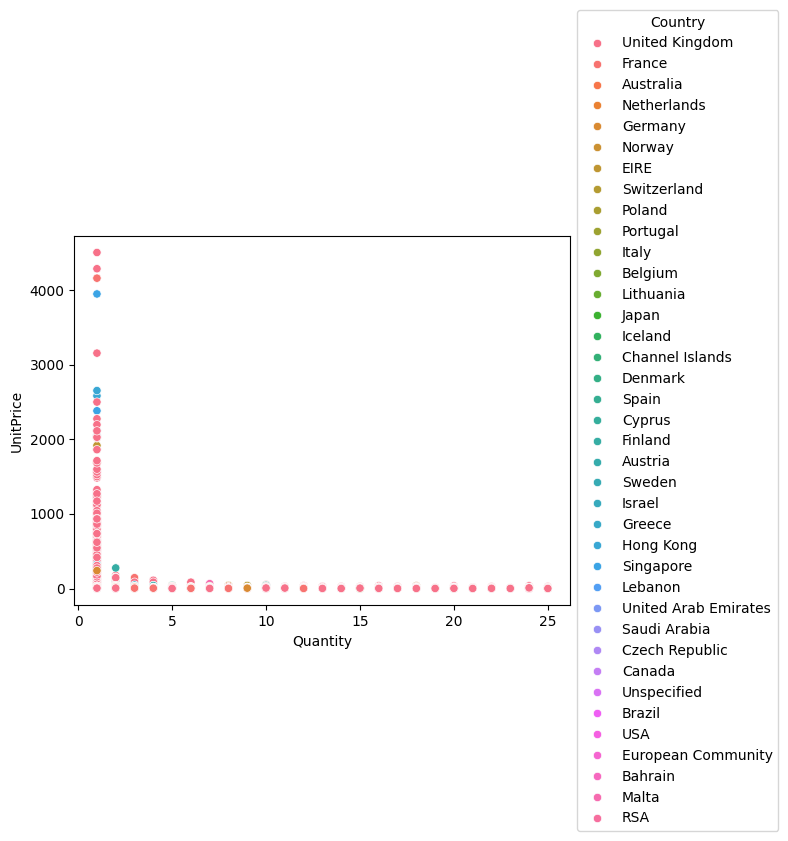

In [236]:
sns.scatterplot(data=df, x='Quantity', y='UnitPrice', hue='Country')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Country')
plt.show()

☎

ヒストグラムみたいになったけど合っているのだろうか。



---



In [237]:
# 箱ひげ図
# 国ごとをX軸、総購入金額をY軸に描写

In [238]:
#オーストラリアで試してみる。
country_value_aus =  df[df['Country'] == 'Australia']
country_value_aus.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
197,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6,2010-12-01 10:03:00,8.50,12431.0,Australia,51.0
198,536389,21622,VINTAGE UNION JACK CUSHION COVER,8,2010-12-01 10:03:00,4.95,12431.0,Australia,39.6
199,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2010-12-01 10:03:00,1.25,12431.0,Australia,15.0
200,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,2010-12-01 10:03:00,5.45,12431.0,Australia,32.7
201,536389,35004G,SET OF 3 GOLD FLYING DUCKS,4,2010-12-01 10:03:00,6.35,12431.0,Australia,25.4


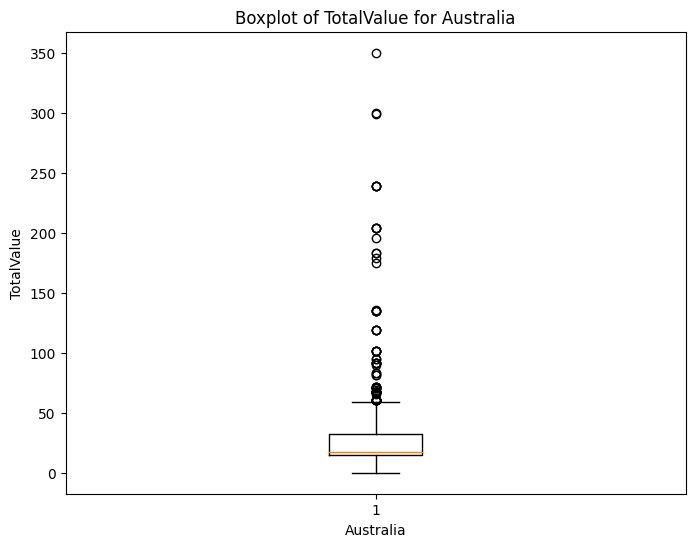

In [239]:
# AustraliaのTotalValueデータを取得
australia_data = country_value_aus['TotalValue']

# 箱ひげ図を描画
plt.figure(figsize=(8, 6))
plt.boxplot(australia_data)
plt.title('Boxplot of TotalValue for Australia')
plt.xlabel('Australia')
plt.ylabel('TotalValue')
plt.show()


In [240]:
australia_data.describe()

count    578.000000
mean      31.641159
std       41.304610
min        0.420000
25%       14.850000
50%       17.700000
75%       33.000000
max      350.000000
Name: TotalValue, dtype: float64

In [241]:
df_country_totalvalue.shape

(38, 2)

In [242]:
def country_name(num):
  country = df_country_totalvalue.loc[num, 'Country']
  return country

country_name(0)

'Australia'

In [243]:
for i in range(38):
  print(country_name(i))

Australia
Austria
Bahrain
Belgium
Brazil
Canada
Channel Islands
Cyprus
Czech Republic
Denmark
EIRE
European Community
Finland
France
Germany
Greece
Hong Kong
Iceland
Israel
Italy
Japan
Lebanon
Lithuania
Malta
Netherlands
Norway
Poland
Portugal
RSA
Saudi Arabia
Singapore
Spain
Sweden
Switzerland
USA
United Arab Emirates
United Kingdom
Unspecified


In [244]:
 for i in range(len(df_country_totalvalue)):
    country_value = df[df['Country'] == country_name(i)]

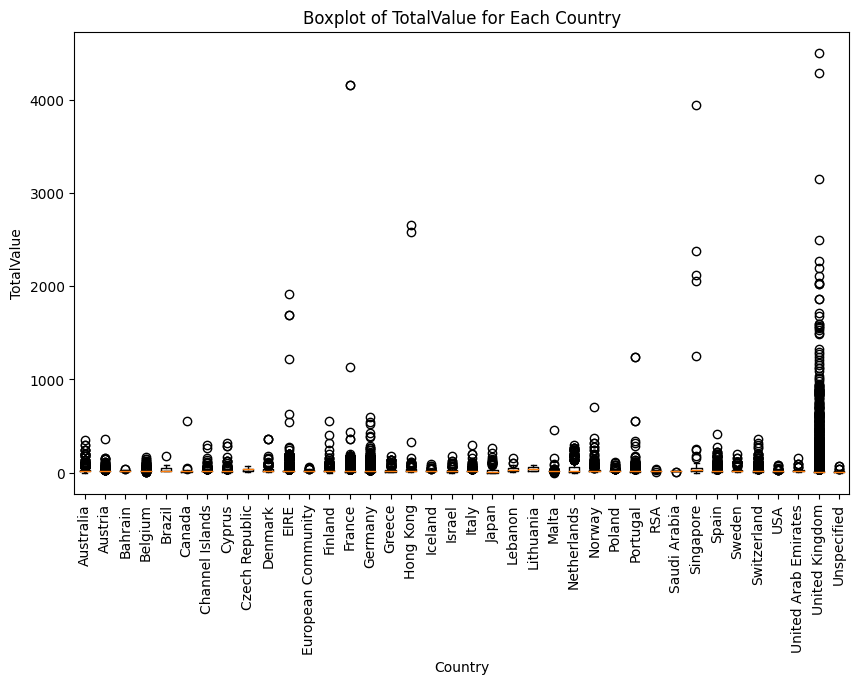

In [245]:
country_data_list = []

# 各国のデータをリストに追加
for i in range(len(df_country_totalvalue)):
    country_name_i = country_name(i)
    country_value = df[df['Country'] == country_name_i]['TotalValue']
    country_data_list.append(country_value)

# 箱ひげ図を描画
plt.figure(figsize=(10, 6))
plt.boxplot(country_data_list, labels=df_country_totalvalue['Country'])
plt.xticks(rotation=90)
plt.title('Boxplot of TotalValue for Each Country')
plt.xlabel('Country')
plt.ylabel('TotalValue')
plt.show()


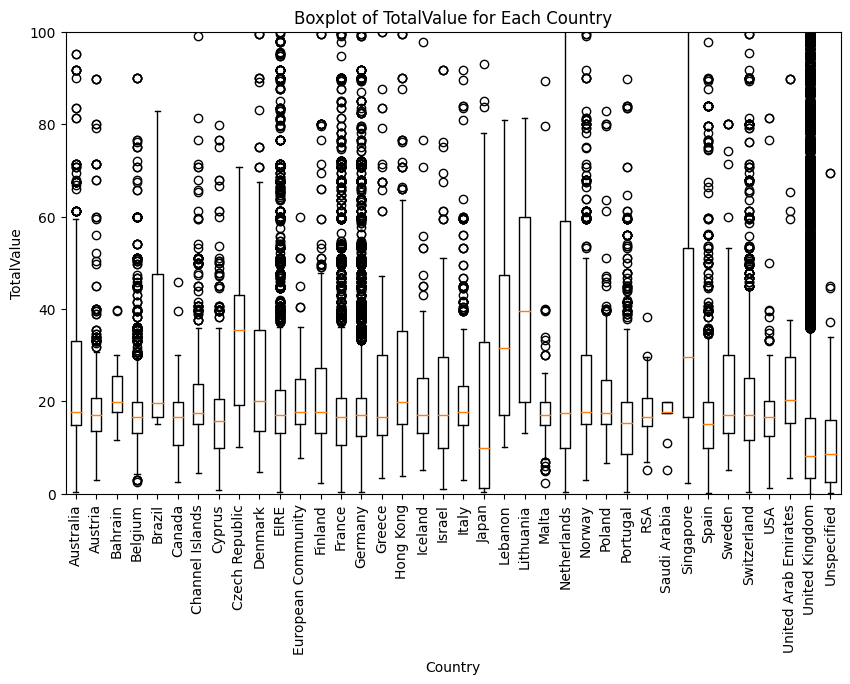

In [246]:
plt.figure(figsize=(10, 6))
plt.boxplot(country_data_list, labels=df_country_totalvalue['Country'])
plt.xticks(rotation=90)
plt.title('Boxplot of TotalValue for Each Country')
plt.xlabel('Country')
plt.ylabel('TotalValue')
plt.ylim(0, 100)
plt.show()

:

☎

箱ひげ図はこのままでいいのだろうか？

ここから外れ値を除いていく作業も必要なのだろうか？



---



# データ集計・分析

次の内容を、Python（主にPandas）と、SQLを使ってそれぞれ集計してください。（両方が難しい場合は、どちらか一方でも構いません。）

データ集計・分析では、df_sampleではなくdfを使うようにしてください

## 参考

Pythonファイル内でSQLを用いる方法

```
%%bash
pip install duckdb-engine
```

```
# ライブラリインポート
import duckdb
```

```
# SQL実行
df_output = duckdb.query(
  f"""
  SELECT -- ここに必要な処理を書く
  FROM df -- テーブルには、Pandasのデータフレームを利用
  """
).to_df()
```

In [247]:
import duckdb

In [248]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [249]:
# 1. 2011年1～6月の期間における、商品（StockCode, Description）ごとの合計売上金額を算出し、金額が高い順に順位をつけてください

In [250]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
TotalValue     float64
dtype: object

In [251]:
#InvoiceDateがオブジェクト型だったのでデータタイムに直す。
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [252]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalValue            float64
dtype: object

In [253]:
filtered_data = df[(df['InvoiceDate'] >= '2011-01-01') & (df['InvoiceDate'] < '2011-07-01')]
filtered_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,19.5
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.5
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.5
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,10.5
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,12.5


In [254]:
a = filtered_data.query("Description == 'JUMBO BAG PINK POLKADOT'")
a.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,19.5
42856,540023,22386,JUMBO BAG PINK POLKADOT,20,2011-01-04 12:58:00,1.95,15039.0,United Kingdom,39.0
45647,540275,22386,JUMBO BAG PINK POLKADOT,20,2011-01-06 12:11:00,1.95,13680.0,United Kingdom,39.0
45675,540276,22386,JUMBO BAG PINK POLKADOT,20,2011-01-06 12:16:00,1.95,14680.0,United Kingdom,39.0
45758,540278,22386,JUMBO BAG PINK POLKADOT,4,2011-01-06 12:31:00,1.95,15719.0,United Kingdom,7.8


In [255]:
sales_by_product = filtered_data.groupby(['StockCode', 'Description'])['TotalValue'].sum().reset_index()
sales_by_product.head()

,StockCode,Description,TotalValue
0,10002,INFLATABLE POLITICAL GLOBE,217.78
1,10080,GROOVY CACTUS INFLATABLE,6.38
2,10120,DOGGY RUBBER,6.72
3,10123C,HEARTS WRAPPING TAPE,2.60
4,10124A,SPOTS ON RED BOOKCOVER TAPE,3.36


In [256]:
sales_by_product.shape

(3464, 3)

In [257]:
sales_by_product_sorted = sales_by_product.sort_values(by='TotalValue', ascending=False)
sales_by_product_sorted.head()

,StockCode,Description,TotalValue
3454,DOT,DOTCOM POSTAGE,65425.44
1266,22423,REGENCY CAKESTAND 3 TIER,55421.83
3455,M,Manual,29819.22
3457,POST,POSTAGE,27804.43
2334,47566,PARTY BUNTING,24665.24


In [258]:
sales_by_product_sorted.tail()

,StockCode,Description,TotalValue
2778,84827,ASS DES PHONE SPONGE CRAFT STICKER,0.650
98,17174,ASSTD RASTA KEY-CHAINS,0.420
2562,84227,HEN HOUSE W CHICK IN NEST,0.420
2485,79149B,SILICON STAR BULB BLUE,0.420
3456,PADS,PADS TO MATCH ALL CUSHIONS,0.001


In [259]:
sales_by_profuct_sql = duckdb.query(
  f"""
  SELECT StockCode, Description, SUM(TotalValue) AS TotalSales
  FROM df
  WHERE InvoiceDate BETWEEN '2011-01-01' AND '2011-06-31'
  GROUP BY StockCode, Description
  ORDER BY TotalSales DESC
  """
).to_df()

sales_by_profuct_sql.head()

,StockCode,Description,TotalSales
0,DOT,DOTCOM POSTAGE,65425.44
1,22423,REGENCY CAKESTAND 3 TIER,55421.83
2,M,Manual,29819.22
3,POST,POSTAGE,27804.43
4,47566,PARTY BUNTING,24665.24


In [260]:
sales_by_profuct_sql_a = duckdb.query(
  f"""
  SELECT StockCode, Description, SUM(TotalValue) AS TotalSales
  FROM df
  WHERE EXTRACT(year FROM InvoiceDate) = 2011
  AND EXTRACT(month FROM InvoiceDate) BETWEEN 1 AND 6
  GROUP BY StockCode, Description
  ORDER BY TotalSales DESC
  """
).to_df()

sales_by_profuct_sql_a.head()

,StockCode,Description,TotalSales
0,DOT,DOTCOM POSTAGE,65425.44
1,22423,REGENCY CAKESTAND 3 TIER,55421.83
2,M,Manual,29819.22
3,POST,POSTAGE,27804.43
4,47566,PARTY BUNTING,24665.24


Pythonだとひとつひとつ確認して実行するのに手間がかかる。

もっと簡潔にコードを書く方法もあるのだろうか。

SQLはひとつのコードの中で都度実行しつつデータフレームがどうなっているか確認出来て良い気がする。



---



In [261]:
# 2. #1で出した売り上げ金額が高い順に並べて、金額の累計が総売上金額の70%以下をAランク、70~90%以下をBランク、それ以降をCランクとしてラベルをつけてください
# 売り上げの70%が上位何%の商品数で占められているかを計算してください

# 参考：https://gmo-research.jp/research-column/abc-analysis

In [262]:
##1のsales_by_product_sortedを利用していく。
sales_by_product_sorted.head()

,StockCode,Description,TotalValue
3454,DOT,DOTCOM POSTAGE,65425.44
1266,22423,REGENCY CAKESTAND 3 TIER,55421.83
3455,M,Manual,29819.22
3457,POST,POSTAGE,27804.43
2334,47566,PARTY BUNTING,24665.24


In [263]:
#累計総売り上げ金額をデータフレームに追加する。 TotalValueを.cumcum()する。
sales_by_product_sorted['CumulativeValue'] = sales_by_product_sorted['TotalValue'].cumsum()
#総売り上げを算出する。　すべてのTotalValueを合計する。
total_sales_sum = sales_by_product_sorted['TotalValue'].sum()
#Rankデータフレームを追加して、累計総売り上げ/総売り上げから70％、70～90％、それ以降に分けてABCのラベルをつける。
sales_by_product_sorted['Rank'] = pd.cut(sales_by_product_sorted['CumulativeValue'] / total_sales_sum, bins=[0, 0.7, 0.9, 1.0], labels=['A', 'B', 'C'])
#Cumulativesales列に累計総売り上げ金額、RankにABCのランクが追加されたか確認する。
sales_by_product_sorted.head()

,StockCode,Description,TotalValue,CumulativeValue,Rank
3454,DOT,DOTCOM POSTAGE,65425.44,65425.44,A
1266,22423,REGENCY CAKESTAND 3 TIER,55421.83,120847.27,A
3455,M,Manual,29819.22,150666.49,A
3457,POST,POSTAGE,27804.43,178470.92,A
2334,47566,PARTY BUNTING,24665.24,203136.16,A


In [264]:
#総商品数＝行を数える
len(sales_by_product_sorted)

3464

In [265]:
#RankAが占める商品数
a_products_70_percent = len(sales_by_product_sorted.query("Rank == 'A'"))
#総商品数のうち、RankAが占める商品数の割合
a_70_percent = (a_products_70_percent / len(sales_by_product_sorted)) * 100
print(f"売り上げの70%が上位{round(a_70_percent, 1)}%の商品数で占められている。")

売り上げの70%が上位15.0%の商品数で占められている。


なんか違う気がする。

これだと売り上げの上位70％が加味されてない？

「売り上げの70%が上位何%の商品数で占められているかを計算してください」

は、ランクがAなのは全体の何割？ということか。あ、合ってるのか…？

ABCランク毎の商品数の割合


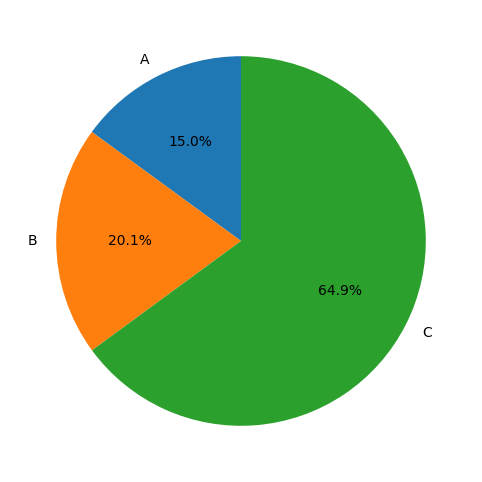

In [266]:
print('ABCランク毎の商品数の割合')
product_counts = sales_by_product_sorted.groupby('Rank').size()
plt.figure(figsize=(8, 6))
plt.pie(product_counts, labels=product_counts.index, autopct='%1.1f%%', startangle=90)
plt.show()

**つまり何をしたのか**

降順にしたデータのTotalValue累積合計を追加して、データフレームCumulativeValueに入れる。

商品の累積合計70％以下をA、70～90％をB、それ以降をCとしてラベルを付ける。

総商品数＝すべての行の数、Aランクの商品数＝Aのラベルがついた行の数

Aランクの商品数/総商品数を求めることで、売り上げの70％（Aランク）が総商品数のうち何％を占めているかを求められる。


In [267]:
# SQLでどうやっていこうかな
df_output = duckdb.query(
  f"""
  SELECT -- ここに必要な処理を書く
  FROM df -- テーブルには、Pandasのデータフレームを利用
  """
).to_df()

ParserException: Parser Error: SELECT clause without selection list

In [ ]:
# 3. すべての期間において、顧客ごとの購入金額を算出し、金額が高い順に同じ人数になるように、10グループを作成してください

In [ ]:
df.head()

**何をするべきか。**

必要なデータ：df, CustomerID, TotalValue

CustomerIDに欠損値が多かったのでデータを確認して削除を検討する。

各CustomerIDに対しての合計購入金額を算出してデータフレーム列（TotalParchase)に加える。

ToralParchase列を降順に並べる。

CustomerIDの行数を取得して、10で割った数ごとに１～１０の番号を振る(RankParchase)。

In [ ]:
# 4. すべての期間において、顧客ごとのRFM分析（R:最終購入日、F:購入回数、M:購入金額）を行ってください

**何をするべきか**

必要なデータ：CustemerID, InvoiceDate, TotalValue

作るデータフレーム列：CustemerID, LastParchaseDate, CumulativeParchase, TotalParchase

dfからCustemerIDを取得してグループ化する？

CustemerIDの最終購入日をLastParchaseDate列に入れる。

CustemerID毎のdfでの出現回数をCumulativeParchase列に入れる？

CustemerIDのTotalValue.sumをTotalParchase列に入れる？



In [ ]:
# 5. すべての期間において、国ごとの総売り上げを月の順番で並べてください

In [ ]:
# 6. 2011年1～6月の期間における、購入者が500人以上の商品のうち、最もファンが多い順に並べてください
# ヒント：リピート率（https://www.tsuhan-marketing.com/blog/basic/regarding_repeatrate）

In [ ]:
# 7. 2011年における、購買の売上分解ツリー（売上のロジックツリー）を作成してください
# ツリーの描写は不要です。必要な項目を出力してください

In [ ]:
# 8. 2011年1～6月の期間において、バスケット分析を行ってください

In [ ]:
# 9. 2011年1～6月を前期間、7～12月を後期間にして、「84406B」（CREAM CUPID HEARTS COAT HANGER）の商品を前期間に購入した人が、後期間に購入した商品を分析してください

In [ ]:
# 下記は難易度高なので、できればでOKです。

# 10. 購買の傾向をもとに、商品同士のネットワーク図を作成してください
# ネットワーク図：https://www.sejuku.net/blog/91371
#
# ※この分析は、SQLとPythonそれぞれではなく、組み合わせて分析してください